In [1]:
#import required libraries
import os
import pandas as pd
from tqdm.notebook import tqdm
import datetime
import matplotlib.pyplot as plt

In [2]:
BASEPATH = '/home/giulio/Repositories/ukrainenewsscraper'
RAWPATH = BASEPATH + os.sep + 'Raw' + os.sep #Path to raw data folder

In [3]:
#Days of interest. Change the range here to study only a certain amount of time (e.g. 1 month)
firstDay = '2022-02-24'
lastDay = '2022-03-24'

In [4]:
KEYWORDS = ['bambino','bambina','bambini', 'child','children','infants']

# Preprocessing

Put the file together and get em ready for analysis.

In [5]:
#open all the datasets and merge them together
dfs = []
for folder in os.listdir(RAWPATH):
    dfs.append(pd.read_csv(RAWPATH + folder + '/' + folder.lower() + '.csv').assign(Source=folder))

df = pd.concat(dfs).drop(['Type','Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1)
del(dfs) #free some memory

print('The shape of the dataframe is', df.shape)

The shape of the dataframe is (5151, 7)


In [6]:
df.head()

,Title,url,Date,Subtitle,Article,Source,ID
0,"Wsj: ""Ue ha proposto di sanzionare anche le fi...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:19:00,NaN,La Ue ha proposto di sanzionare anche le due f...,TGCOM24,NaN
1,"Usa sanzionano Hydra, maggiore piattaforma del...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:01:00,NaN,"Gli Usa hanno sanzionato Hydra, la più grande ...",TGCOM24,NaN
2,Casa Bianca: nuove sanzioni a dirigenti govern...,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:42:00,NaN,Le nuove sanzioni Usa colpiranno dirigenti del...,TGCOM24,NaN
3,"Bucha, la Russia si difende dalle accuse | In ...",https://www.tgcom24.mediaset.it/mondo/ucraina-...,2022-04-05 22:20:26,"La Nato: ""Fase cruciale, Mosca vuole il Donbas...",La guerra in Ucraina entra nel quarantunesimo ...,TGCOM24,NaN
4,Esplosioni udite nella regione di Leopoli,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:20:00,NaN,Esplosioni sono state udite nell'ovest dell'Uc...,TGCOM24,NaN


Some preprocessing is needed. We need to merge subtitles and Article, as not all the sources have a subtitle. 
We can also add the language of the article as a variable.

In [7]:
df.Article = df.Subtitle.astype(str).replace('nan','') + df.Article
df = df.drop('Subtitle', axis=1)
df.head()

,Title,url,Date,Article,Source,ID
0,"Wsj: ""Ue ha proposto di sanzionare anche le fi...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:19:00,La Ue ha proposto di sanzionare anche le due f...,TGCOM24,NaN
1,"Usa sanzionano Hydra, maggiore piattaforma del...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:01:00,"Gli Usa hanno sanzionato Hydra, la più grande ...",TGCOM24,NaN
2,Casa Bianca: nuove sanzioni a dirigenti govern...,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:42:00,Le nuove sanzioni Usa colpiranno dirigenti del...,TGCOM24,NaN
3,"Bucha, la Russia si difende dalle accuse | In ...",https://www.tgcom24.mediaset.it/mondo/ucraina-...,2022-04-05 22:20:26,"La Nato: ""Fase cruciale, Mosca vuole il Donbas...",TGCOM24,NaN
4,Esplosioni udite nella regione di Leopoli,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:20:00,Esplosioni sono state udite nell'ovest dell'Uc...,TGCOM24,NaN


In [8]:
df = df.assign(Language = df.Source.replace({'TGCOM24':'it','Open':'it','cna':'en','ilpost':'it'}))

In [9]:
df.Language.value_counts()

it    4195
en     956
Name: Language, dtype: int64

In [10]:
df.loc[df['ID'].isnull(), 'ID'] = df.loc[df['ID'].isnull()].index

We can also assign an ID to articles from TGCOM24, given that no ID was provided.

In [11]:
df.head()

,Title,url,Date,Article,Source,ID,Language
0,"Wsj: ""Ue ha proposto di sanzionare anche le fi...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:19:00,La Ue ha proposto di sanzionare anche le due f...,TGCOM24,0,it
1,"Usa sanzionano Hydra, maggiore piattaforma del...",https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 23:01:00,"Gli Usa hanno sanzionato Hydra, la più grande ...",TGCOM24,1,it
2,Casa Bianca: nuove sanzioni a dirigenti govern...,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:42:00,Le nuove sanzioni Usa colpiranno dirigenti del...,TGCOM24,2,it
3,"Bucha, la Russia si difende dalle accuse | In ...",https://www.tgcom24.mediaset.it/mondo/ucraina-...,2022-04-05 22:20:26,"La Nato: ""Fase cruciale, Mosca vuole il Donbas...",TGCOM24,3,it
4,Esplosioni udite nella regione di Leopoli,https://www.tgcom24.mediaset.it//temporeale/te...,2022-04-05 22:20:00,Esplosioni sono state udite nell'ovest dell'Uc...,TGCOM24,4,it


And fix the weird \n remaining in some titles and articles

In [12]:
df.Title = [x.replace('\n','') for x in  df.Title]
df.Article = [str(x).replace('\n',' ') for x in df.Article]

We can limit the dataframe to a period of interest. 

In [13]:
#time period to study
df = df[(pd.to_datetime(df.Date) > pd.to_datetime(firstDay)) & (pd.to_datetime(df.Date) < pd.to_datetime(lastDay))]
print(len(df), 'Valid articles in selected dates range')

3421 Valid articles in selected dates range


# Exploratory Analysis

TGCOM24    2255
Open        660
cna         462
ilpost       44
Name: Source, dtype: int64

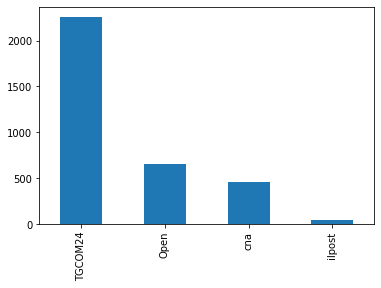

In [14]:
#How many articles per source?
df.Source.value_counts().plot.bar()

df.Source.value_counts()

it    2959
en     462
Name: Language, dtype: int64

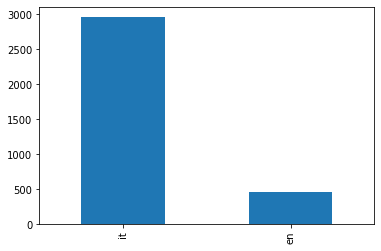

In [15]:
#How many articles per language?
df.Language.value_counts().plot.bar()
df.Language.value_counts()

Text(0.5, 1.0, 'Number of articles by day')

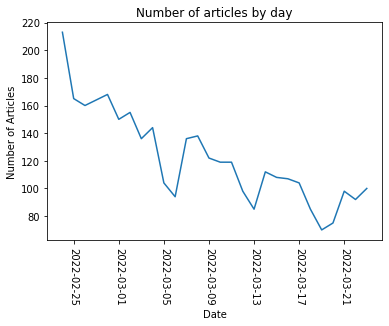

In [16]:
datecount = pd.DataFrame(pd.to_datetime(df['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
plt.plot(datecount.Date, datecount.Count)
plt.xticks(rotation=-90)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of articles by day')

In [17]:
#Create a date only field, move datetime to datetime field
df = df.assign(Datetime = df.Date)
df.Date = pd.to_datetime(df['Date']).dt.date

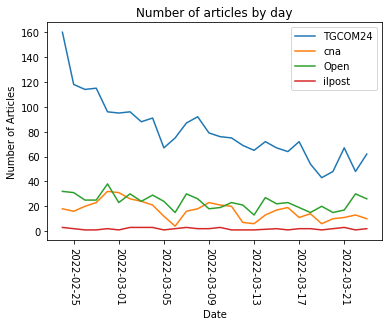

In [18]:
#see the number of articles by source
for source in df.Source.unique():
    t = pd.DataFrame(df[df.Source == source].Date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
    plt.plot(t.Date, t.Count, label=source)
    
plt.xticks(rotation=-90)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of articles by day')
plt.legend()

In [23]:
df.Article

763    Il Regno Unito consegnerà altri 6mila missili ...
764    Berlino vuole fornire altri 2mila lanciarazzi ...
765    Le autorità di Kiev hanno informato l'Agenzia ...
766    Il presidente ucraino, Volodymyr Zelensky, ha ...
767    Il Consiglio di Sicurezza dell'Onu ha bocciato...
                             ...                        
113    L’inaspettato carisma di Zelensky  Il presiden...
114    Breve storia dell’Ucraina  Chi ci ha vissuto e...
115    Com’è fatta l’Ucraina  Qualche indicazione sul...
116    Il ruolo della Bielorussia nell’invasione  Par...
117    Che rapporto ha Putin con l’epoca sovietica  I...
Name: Article, Length: 3421, dtype: object

In [19]:
# Rapid Analysis:

df = df.assign(hasKeyword = [any([keyword in article for keyword in KEYWORDS]) for article in df.Article])

In [20]:
df.hasKeyword.value_counts()

False    3101
True      320
Name: hasKeyword, dtype: int64

Text(0.5, 1.0, 'Number of articles contaning keyword by day')

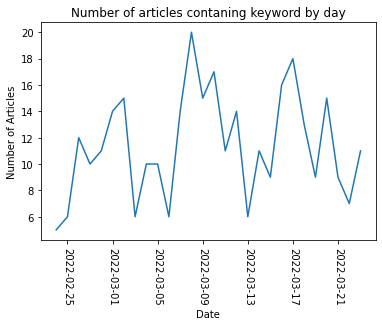

In [21]:
#same plot as above but only for articles with keywords
datecount = pd.DataFrame(pd.to_datetime(df[df.hasKeyword == True]['Date']).dt.date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
plt.plot(datecount.Date, datecount.Count)
plt.xticks(rotation=-90)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of articles contaning keyword by day')

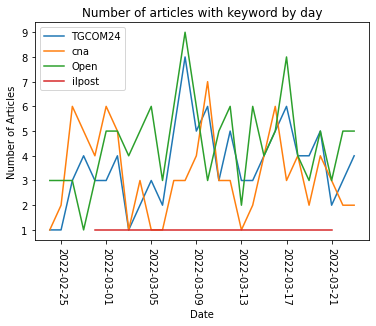

In [22]:
#see the number of articles by source
for source in df.Source.unique():
    t = pd.DataFrame(df[(df.Source == source) & (df.hasKeyword)].Date.value_counts()).rename({'Date':'Count'}, axis=1).rename_axis('Date').sort_values(by='Date').reset_index()
    plt.plot(t.Date, t.Count, label=source)
    
plt.xticks(rotation=-90)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of articles with keyword by day')
plt.legend()